# Calculate Geological Complexity (Fractal Dimension)

> MIT License  
> Copyright (c) 2019 Elias Martins Guerra Prado  
> source: https://github.com/Eliasmgprado/MineralProspectivityMapping  
> e-mail: elias.prado@cprm.gov.br  


### References


- Ford, A., Blenkinsop, T.G., 2008. Evaluating geological complexity and complexity gradients as controls on copper mineralisation, Mt Isa Inlier. Aust. J. Earth Sci. 55, 13–23.

- Hodkiewicz, P., 2003, The Interplay Between Physical and Chemical Processes in the Formation of World-Class Orogenic Gold Deposits in the Eastern Goldfields Province , Western Australia.

![alt text](imgs/Hodkiewicz.png)


## Version of Python Libraries
- gdal                      2.3.3  
- geopandas                 0.4.1  
- pandas                    0.24.2  
- matplotlib                3.0.3  
- rasterio                  1.0.21  
- numpy                     1.16.3  
- scipy                     1.2.1  

In [1]:
from osgeo import gdal, ogr
import osgeo.ogr
import osgeo.osr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist

import math
import numpy as np
from IPython.display import display
from matplotlib.ticker import FuncFormatter
from scipy import stats

plt.style.available
plt.style.use('fivethirtyeight')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.5f}'.format

rc={'savefig.dpi': 350, 'figure.autolayout': False, 'figure.figsize': [15, 10], 'axes.labelsize': 18,\
   'axes.titlesize': 22, 'font.size': 8, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 18, 'ytick.labelsize': 15}

%matplotlib inline


# Input Parameters  (<span style="color:green">MODIFY THIS CELL</span>)
> Change this cell and run all cells bellow

In [2]:
#1 SHAPE WITH WORK AREA (AREA BOUNDARIES):
work_area = 'D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\Wofe\sig\Work_Area.shp'

#2 RESULTS OUTPUT FOLDER:
out_folder = 'D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\\' #Folder path
out_work_area_raster = out_folder + 'work_area_raster.tif'#work area raster
out_work_grid = out_folder + 'work_grid.shp' #work grid

#3 SAMPLING GRID SPACING SIZE (Meters):
#distance between grid points
grid_size = 5000 

#4 FEATURES TO BE ANALYSED:
#shape file with structures and/or geological contacts
input_shape = 'D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\para_lito_contacts_s_SRTM_line.shp' 

#5 GET NUMBER OF RECURSIONS: 
#number of dimensioins (scales) used to compute the fractal dimension
Dimlimit = 5

#6 Initial Fractal Size (Meters):
#cell size of first fractal dimension. Usually set iqual to SAMPLING GRID SPACING
init_size = 5000

#7 Output Fractal_dimension Raster
#output raster
output_fd_raster = out_folder + 'FractalDimension_Carajas.tif'

# <span style="color:red">DO NOT CHANGE THE CELLS BELOW</span>

# Create Base Grid

In [3]:
# Define pixel_size and NoData value of new raster
pixel_size = grid_size
NoData_value = -9999

# Filename of input OGR file
vector_fn = work_area

# Filename of the raster Tiff that will be created
raster_fn = out_work_area_raster

# Open the data source and read in the extent
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer()
x_min, x_max, y_min, y_max = source_layer.GetExtent()
work_area_b = {}
work_area_b['x_min'] = x_min
work_area_b['x_max'] = x_max
work_area_b['y_min'] = y_min
work_area_b['y_max'] = y_max

# Create the destination data source
x_res = math.ceil((x_max - x_min) / pixel_size)
y_res = math.ceil((y_max - y_min) / pixel_size)
target_ds = gdal.GetDriverByName('GTiff').Create(raster_fn, x_res, y_res, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, grid_size, 0, y_max, 0, -grid_size))
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)

# Rasterize
gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[0])

0

In [4]:
r = gdal.Open(out_work_area_raster)
band = r.GetRasterBand(1) #bands start at one
a = band.ReadAsArray().astype(np.float)

(y_index, x_index) = np.nonzero(a != -9999)
print((y_index, x_index))

(upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
print((upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size))


# Init the shapefile stuff..
srs = osgeo.osr.SpatialReference()
#srs.ImportFromProj4('+proj=utm +zone=15 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')
srs.ImportFromWkt(r.GetProjection())

driver = osgeo.ogr.GetDriverByName('ESRI Shapefile')
shapeData = driver.CreateDataSource(out_work_grid)

layer = shapeData.CreateLayer('ogr_pts', srs, osgeo.ogr.wkbPoint)
layerDefinition = layer.GetLayerDefn()


# Iterate over the Numpy points..
grid_points = []
i = 0
for x_coord in x_index:
    x = x_index[i] * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y = y_index[i] * y_size + upper_left_y + (y_size / 2) #to centre the point

    grid_points.append([x,y])
    # DEBUG: take a look at the coords..
    #print ("Coords: " + str(x) + ", " + str(y))

    point = osgeo.ogr.Geometry(osgeo.ogr.wkbPoint)
    point.SetPoint(0, x, y)

    feature = osgeo.ogr.Feature(layerDefinition)
    feature.SetGeometry(point)
    feature.SetFID(i)

    layer.CreateFeature(feature)

    i += 1

shapeData.Destroy()

print ("done! " + str(i) + " points found!")

(array([ 0,  0,  0, ..., 53, 53, 53], dtype=int64), array([ 0,  1,  2, ..., 74, 75, 76], dtype=int64))
(284558.1110000005, 5000.0, 0.0, 9391693.117000002, 0.0, -5000.0)
done! 4158 points found!


## Plot Base Grid

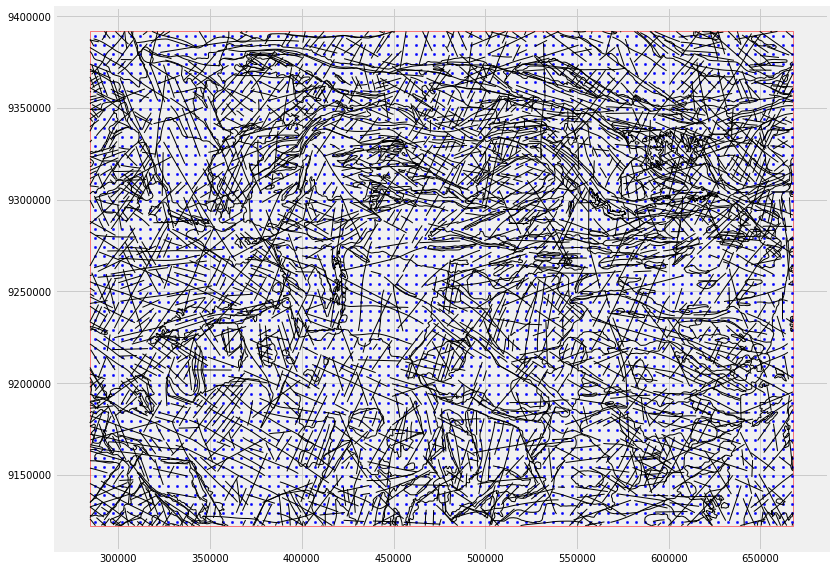

In [5]:
w_grid_gdf = gpd.read_file(out_work_grid)
w_area_gdf = gpd.read_file(work_area)
input_data_gdf = gpd.read_file(input_shape)
#input_data_gdf2 = gpd.read_file(input_shape2)

f, ax = plt.subplots(1, figsize=(15,10))

input_data_gdf.plot(ax=ax, color='black', lw=1)
#input_data_gdf2.plot(ax=ax, color='gray', lw=1)
w_area_gdf.plot(ax=ax, color='none', edgecolor='red')
w_grid_gdf.plot(ax=ax, marker='o', markersize=5, color='blue')
plt.show()

# Calculate Work Area Boundaries and Size of First Fractal Dimension
### First Fractal Dimension = 1/4 Work Area Size

In [6]:
x_min = work_area_b['x_min']
x_max = work_area_b['x_max']
y_min = work_area_b['y_min']
y_max = work_area_b['y_max']
print('work area max/min')
print(x_min,y_min,x_max,y_max)

work_grid_gdf = gpd.read_file(out_work_grid)
print('grid max/min')
print(work_grid_gdf.geometry.x.max())
print(work_grid_gdf.geometry.x.min())
print(work_grid_gdf.geometry.y.max())
print(work_grid_gdf.geometry.y.min())
grid_max_x = work_grid_gdf.geometry.x.max()
grid_min_x = work_grid_gdf.geometry.x.min()
grid_max_y = work_grid_gdf.geometry.y.max()
grid_min_y = work_grid_gdf.geometry.y.min()

x_size = x_max-x_min
y_size = y_max-y_min
print('work area size')
print(x_size,y_size)

box_xsize = init_size
box_ysize = init_size
print('init box size')
print(box_xsize,box_ysize)

work area max/min
284558.1110000005 9122346.745000001 667675.5439999998 9391693.117000002
grid max/min
667058.1110000005
287058.1110000005
9389193.117000002
9124193.117000002
work area size
383117.43299999926 269346.3720000014
init box size
5000 5000


# Aux. Function
## Calculate Slope of Fractal Dimension Line

In [7]:
def print_Fractal_Dimension_curve(x,y):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x),np.log(y))
    fit_line = slope*np.asarray(np.log(x))+intercept
    
#     plt.figure(figsize=(10,7))
#     plt.plot(x,np.exp(fit_line), '-')
#     plt.plot(x, y, 'o')
    
#     plt.title('Fractal Dimension Curve')
#     plt.yscale('log')
#     plt.ylabel('Box Count')
#     plt.xscale('log')
#     plt.xlabel('Box Size (m)')
#     #plt.xlim(xmin, 1)
#     #plt.ylim(0, max(y))
#     ax = plt.gca()
#     #ax.xaxis.set_major_formatter(formatter)
#     ax.yaxis.grid(zorder=0, which="both")
#     ax.xaxis.grid(zorder=0, which="both")
    
#     plt.text((x[int(len(x)/2) - 1] + x[int(len(x)/2)])/2,y[int(len(y)/2)],'D = {:.2f}'.format(-1*slope),fontsize=15,color='black')
#     fig = plt.gcf()

#     #plt.savefig(name + '_' + str(xmin) + '.png', facecolor=fig.get_facecolor(), edgecolor='none',bbox_inches='tight')  
#     plt.show(block=False)

    if math.isnan(slope):
        slope = 0
    return -1*slope

# Create Raster for each Dimension

In [9]:
NoData_value = -9999
def readFile(filename):
    filehandle = gdal.Open(filename)
    band1 = filehandle.GetRasterBand(1)
    geotransform = filehandle.GetGeoTransform()
    geoproj = filehandle.GetProjection()
    Z = band1.ReadAsArray()
    xsize = filehandle.RasterXSize
    ysize = filehandle.RasterYSize
    return xsize,ysize,geotransform,geoproj,Z

def writeFile(filename,geotransform,geoprojection,data):
    (x,y) = data.shape
    format = "GTiff"
    driver = gdal.GetDriverByName(format)
    # you can change the dataformat but be sure to be able to store negative values including -9999
    dst_datatype = gdal.GDT_Float32
    dst_ds = driver.Create(filename,y,x,1,dst_datatype)
    dst_ds.GetRasterBand(1).WriteArray(data)
    dst_ds.SetGeoTransform(geotransform)
    dst_ds.SetProjection(geoprojection)
    dst_ds.GetRasterBand(1).SetNoDataValue(-9999)
    return 1

In [10]:
# Filename of input OGR file
vector_fn = input_shape
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer()
proj = source_layer.GetSpatialRef().ExportToWkt()

NoData_value = -9999
    
for dimension in range(Dimlimit):
   # Define pixel_size and NoData value of new raster
    pixel_size = init_size*2/math.pow(2,dimension+1)

    # Filename of the raster Tiff that will be created
    out_raster = out_folder + 'input_rasterized_{}_.tif'.format(dimension+1)
    raster_fn = out_raster
    
    # Create the destination data source
    x_res = math.ceil(((grid_max_x+init_size)-(grid_min_x-init_size))/pixel_size)
    y_res = math.ceil(((grid_max_y+init_size)-(grid_min_y-init_size))/pixel_size)
    #print((x_res*pixel_size+ grid_min_y))
    print(f'Dimension {dimension}')
    print(f'Pixel Size: {pixel_size:.0f}')
    target_ds = gdal.GetDriverByName('GTiff').Create(raster_fn, x_res, y_res, 1, gdal.GDT_Float32)
    target_ds.SetGeoTransform((grid_min_x-init_size, pixel_size, 0, grid_max_y+init_size, 0, -pixel_size))
    target_ds.SetProjection(proj)
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)
    band.Fill(np.nan)

    # Rasterize
    gdal.RasterizeLayer(target_ds, [1], source_layer, None, None, [1], ['ALL_TOUCHED=TRUE'])
    
    # Close dataset
    target_ds = None
    
    [xsize,ysize,geotransform,geoproj,Z] = readFile(raster_fn)
    #print(Z[np.isnan(Z)])
    #print(Z)
    #print(Z[np.isnan(Z)])
    Z[np.isnan(Z)]= NoData_value
    #print(Z[Z==NoData_value])
    
    
    status = writeFile(raster_fn,geotransform,geoproj,Z)
    
    if status != 1:
        print("I don't think it worked...")
    else:
        print("Success")
        print(f'Saved in: {raster_fn}')

Dimension 0
Pixel Size: 5000
Success
Saved in: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\input_rasterized_1_.tif
Dimension 1
Pixel Size: 2500
Success
Saved in: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\input_rasterized_2_.tif
Dimension 2
Pixel Size: 1250
Success
Saved in: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\input_rasterized_3_.tif
Dimension 3
Pixel Size: 625
Success
Saved in: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\input_rasterized_4_.tif
Dimension 4
Pixel Size: 312
Success
Saved in: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\input_rasterized_5_.tif


## Plot Raster

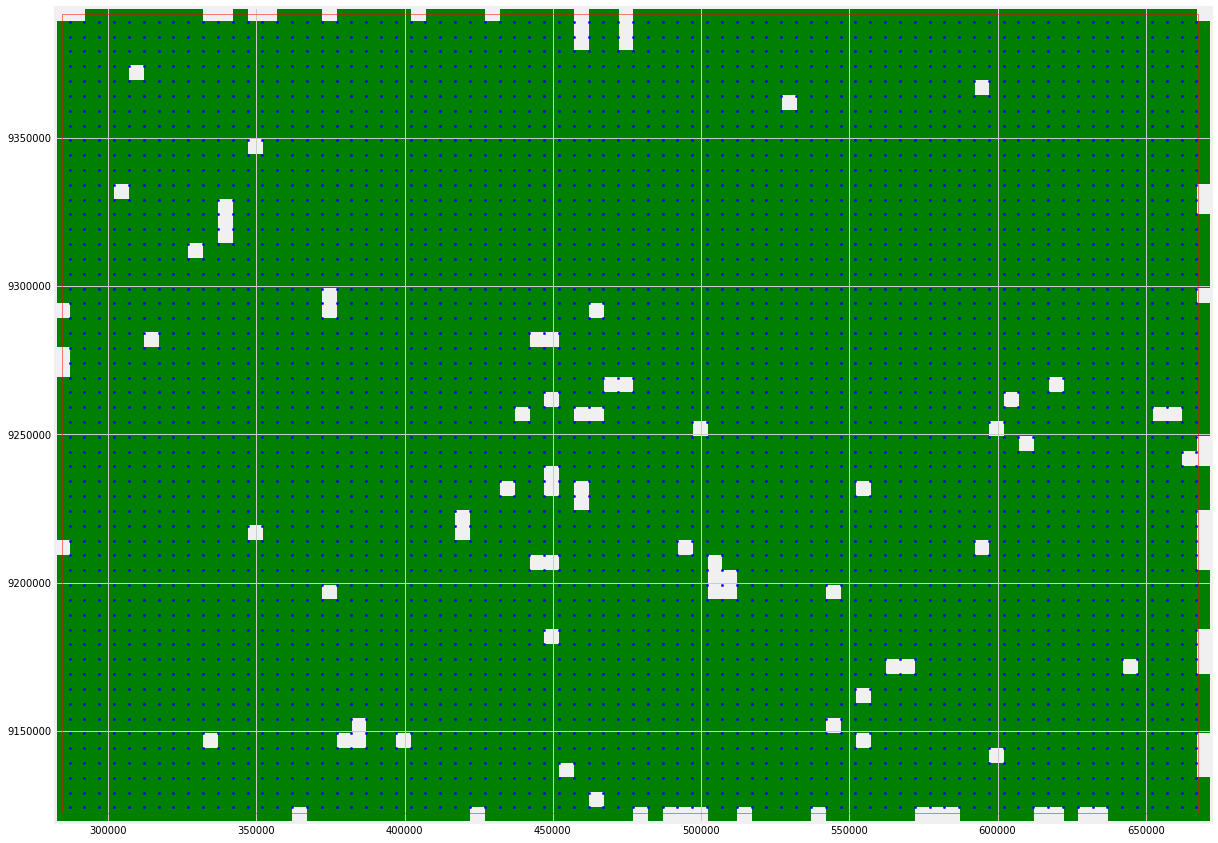

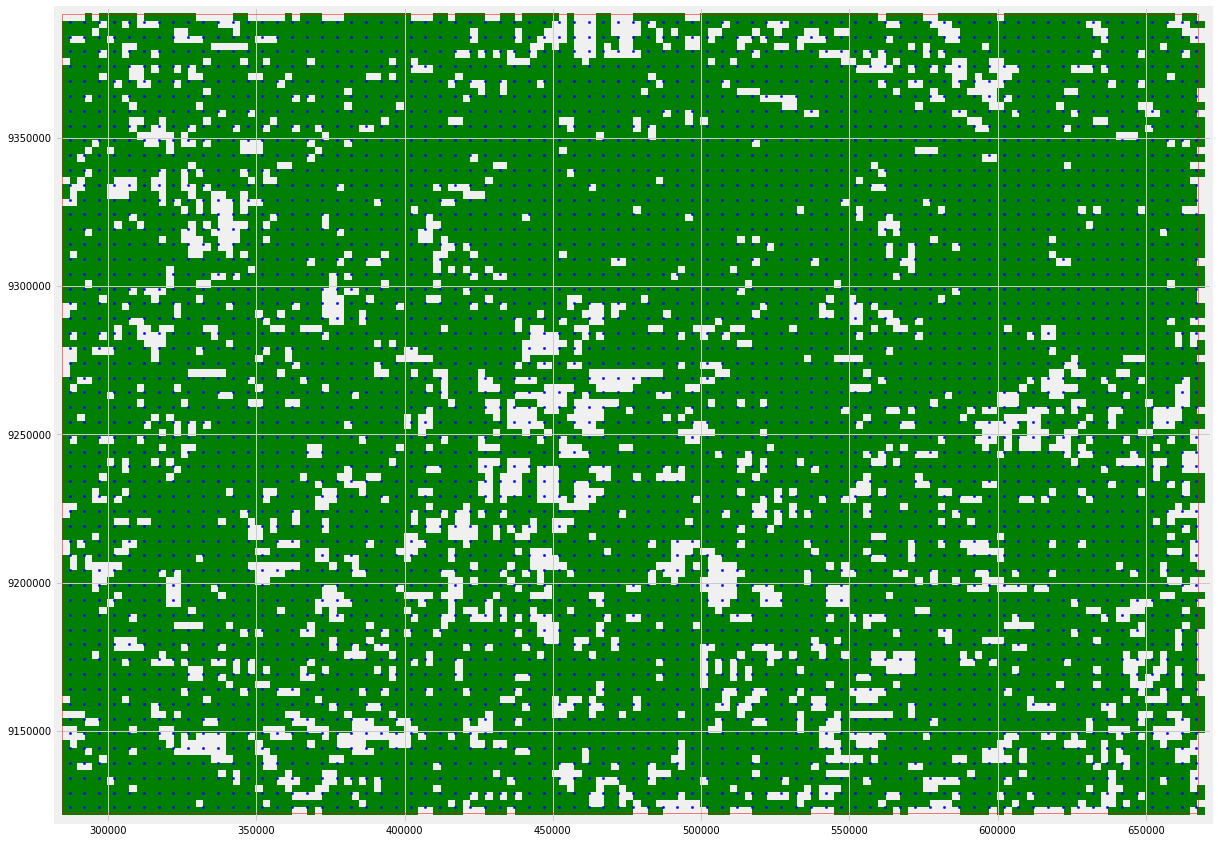

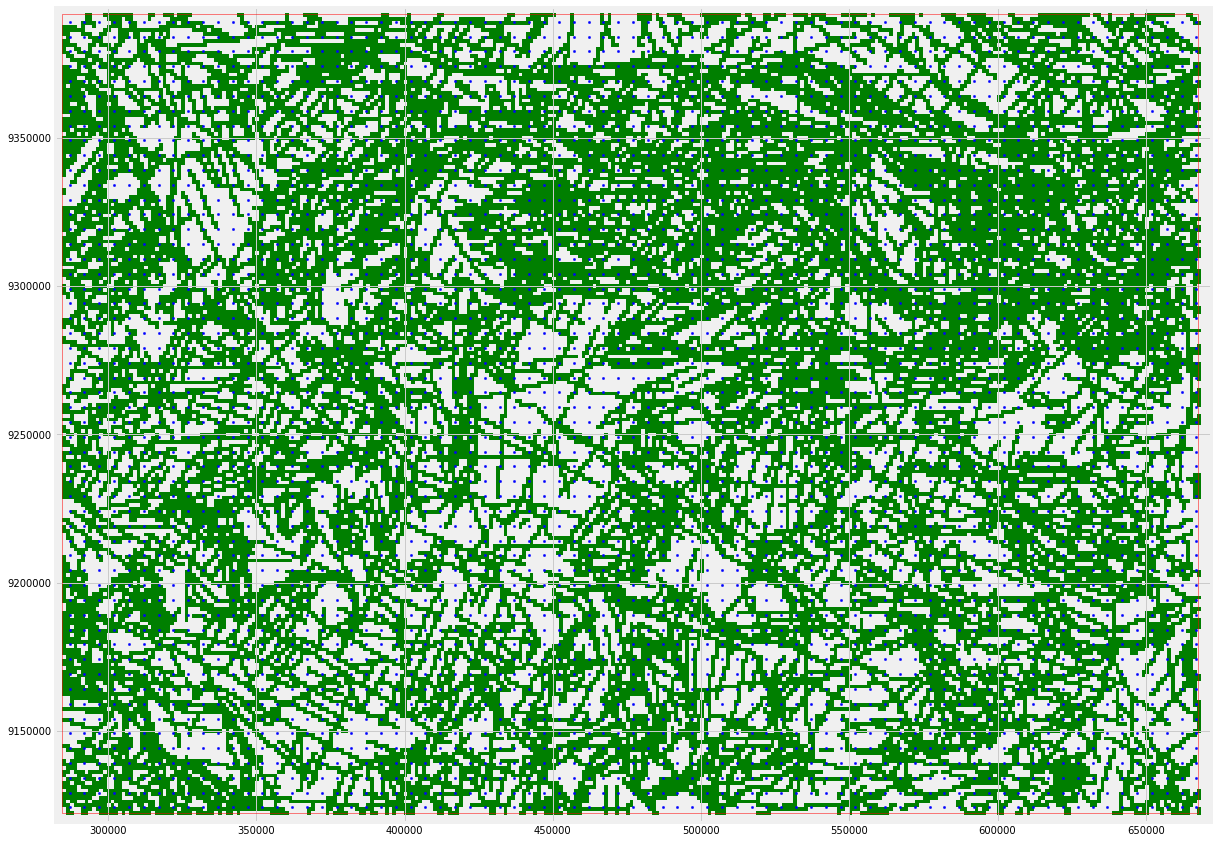

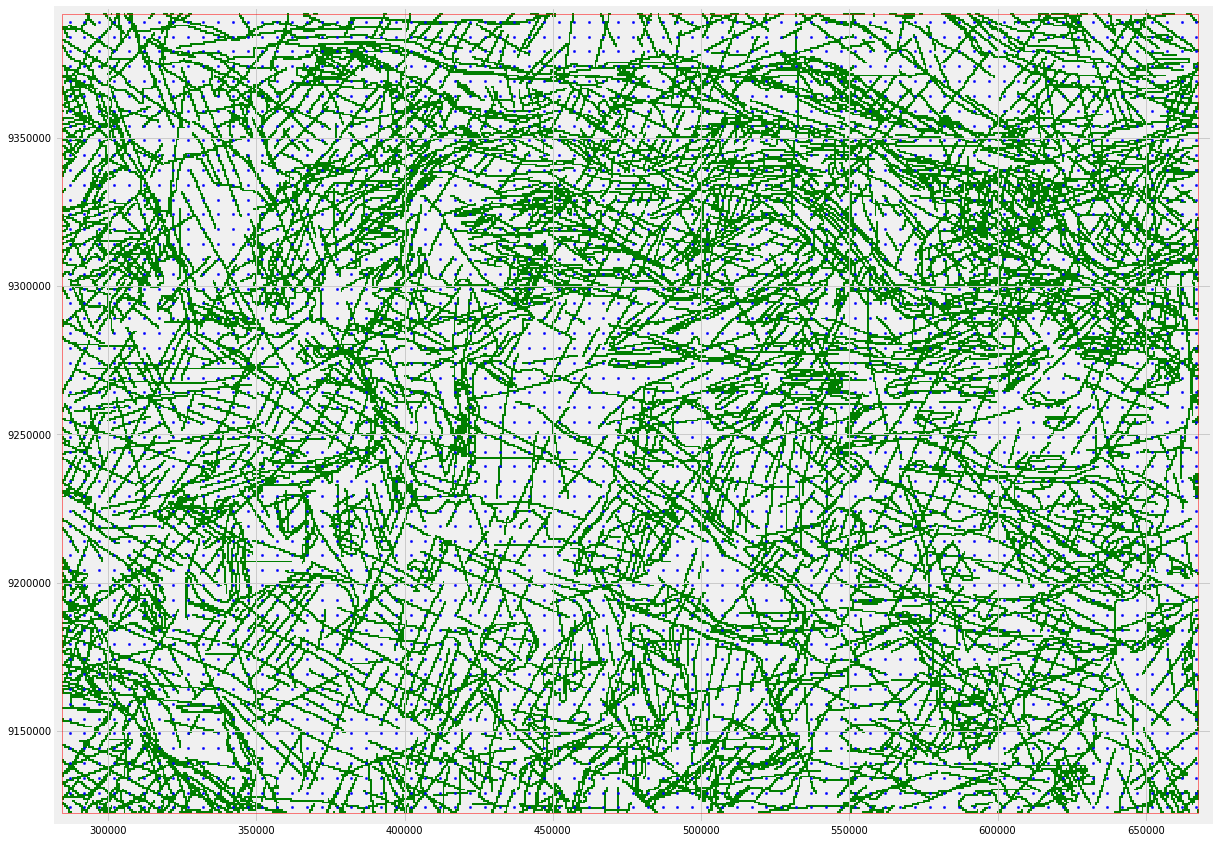

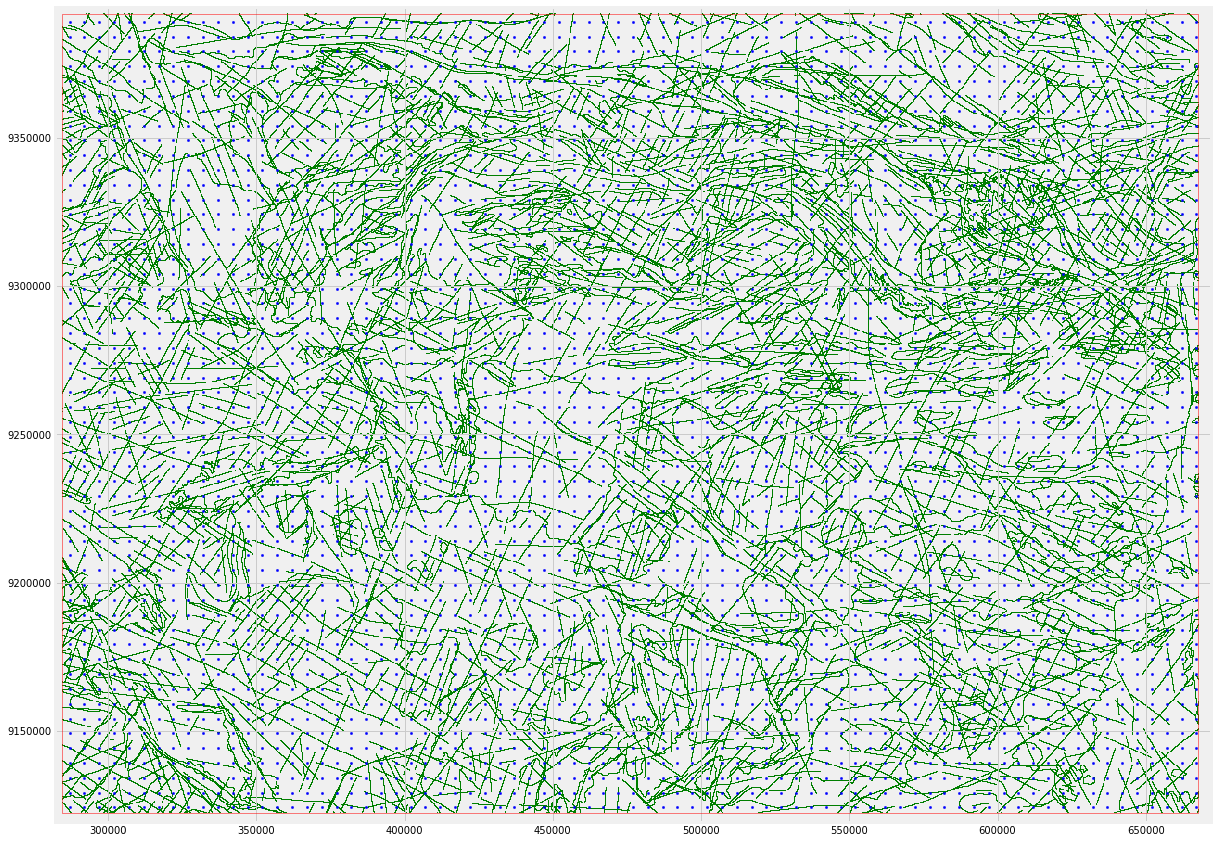

In [11]:
for dimension in range(Dimlimit):
    out_raster = out_folder + 'input_rasterized_{}_.tif'.format(dimension+1)
    #fish_net_gdf = gpd.read_file(fish_net)
    w_area_gdf = gpd.read_file(work_area)
    w_grid_gdf = gpd.read_file(out_work_grid)
    input_raster_625 = rasterio.open(out_raster)

    f, ax = plt.subplots(1, figsize=(20,15))

    show(input_raster_625, cmap='ocean', ax=ax, extent=[grid_min_x-init_size,grid_max_x+init_size,grid_min_y-init_size,grid_max_y+init_size])
    #fish_net_gdf.plot(ax=ax, color='none', edgecolor='black')
    w_area_gdf.plot(ax=ax, color='none', edgecolor='red')
    w_grid_gdf.plot(ax=ax, marker='o', markersize=5, color='blue')
    input_raster_625.close
    plt.show()

# Calculate Fractal Dimension for Grid

In [14]:
grid_vals_ = []
for gi, p_coord in enumerate(grid_points):
    final_box_coord = []
    point_counts = []
    
    x = p_coord[0]
    y = p_coord[1]
    #print(x,y)
    
    box_coord = [[[x-box_xsize,y-box_ysize],[x+box_xsize,y-box_ysize],
                [x+box_xsize,y+box_ysize],[x-box_xsize,y+box_ysize]]]
    
    box_coord = [x-box_xsize, y+box_ysize, x+box_xsize, y-box_ysize]
    
#     box_poly = arcpy.Polygon(
#                     arcpy.Array([arcpy.Point(*coords) for coords in box_coord[0]]))
    output_ = out_folder + 'temp.tif'
    #env.extent=box_poly.extent
    for dimension in range(Dimlimit):
        out_raster = out_folder + 'input_rasterized_{}.tif'.format(dimension+1)
        [xsize,ysize,geotransform,geoproj,Z] = readFile(out_raster)
        
        gdal.Translate(output_, out_raster, format='GTiff', projWin=box_coord, outputSRS=geoproj)
        [xsize,ysize,geotransform,geoproj,Z] = readFile(output_)
        
        #print(g_array)
        point_counts.append(Z.sum())
#         arcpy.CopyFeatures_management(box_poly, out_folder + 'fractal_test.shp')
#         f_boxes = gpd.read_file(out_folder + 'fractal_test.shp')
#         w_grid = gpd.read_file(out_work_grid)
#         input_raster_625 = rasterio.open(out_raster)



#         f, ax = plt.subplots(1, figsize=(15,10))
#         f_boxes.plot(ax=ax, facecolor="none", edgecolor='black')
#         show(input_raster_625, cmap='terrain', ax=ax, extent=[x_min-init_size/2,x_max+init_size/2,y_min-init_size/2,y_max+init_size/2])
#         w_grid.plot(ax=ax, marker='o', markersize=5, )
#         input_raster_625.close()
#         plt.show()
    #print(box_coord)
    print(f'Box Count: {point_counts}')
    x_sizes = [box_xsize/math.pow(2, x) for x in range(Dimlimit)]
    print(f'Box Sizes: {x_sizes}')
    F_dimension = print_Fractal_Dimension_curve(x_sizes,point_counts)
    print(f'Fractal Dimension: {F_dimension}')
    grid_vals_.append(F_dimension)
    
    

Box Count: [2, 6, 14, 32, 65]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.245977312533575
Box Count: [3, 8, 19, 43, 88]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2175202990534377
Box Count: [4, 9, 21, 47, 96]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1554588851677634
Box Count: [4, 11, 29, 64, 131]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2607414384437599
Box Count: [4, 10, 29, 74, 162]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3567225276510835
Box Count: [4, 8, 20, 52, 117]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.24411691573079
Box Count: [4, 9, 25, 56, 120]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2451211111832325
Box Count: [4, 10, 31, 70, 149]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3245691962981927
Box Count: [4, 10, 27, 56, 113]
Box Sizes: [5000.0,

Box Count: [4, 9, 19, 48, 101]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1731460464782433
Box Count: [4, 9, 22, 54, 111]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2173794233421364
Box Count: [4, 10, 29, 79, 176]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.390071589056433
Box Count: [4, 10, 29, 81, 189]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4142406756439405
Box Count: [4, 11, 27, 73, 162]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3410092946011964
Box Count: [4, 8, 18, 46, 96]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1693486957499322
Box Count: [4, 5, 10, 23, 45]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.9185340053828998
Box Count: [3, 4, 7, 12, 23]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.7462161411392868
Box Count: [4, 10, 23, 53, 107]
Box Sizes: [5000.0

Box Count: [4, 16, 48, 105, 232]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4430207507921262
Box Count: [4, 16, 47, 104, 218]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4236808367694942
Box Count: [4, 16, 47, 101, 207]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4045185397750446
Box Count: [4, 15, 46, 99, 206]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4095467078837527
Box Count: [4, 15, 44, 96, 199]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3951321146199933
Box Count: [4, 14, 39, 84, 169]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3386721373285522
Box Count: [4, 14, 43, 106, 225]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4548127914939668
Box Count: [4, 15, 45, 112, 241]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4726242998909005
Box Count: [4, 13, 30, 66, 139]
Box

Box Count: [4, 13, 27, 55, 113]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1721277920213942
Box Count: [4, 12, 24, 48, 97]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1199825684374254
Box Count: [4, 11, 27, 58, 122]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2260024051616045
Box Count: [4, 14, 35, 76, 157]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3029814089169234
Box Count: [4, 14, 31, 65, 133]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2325577761973225
Box Count: [4, 12, 27, 57, 118]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2013213612167268
Box Count: [4, 11, 28, 58, 118]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2163835475213953
Box Count: [4, 12, 29, 62, 127]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.234660318321005
Box Count: [4, 15, 38, 83, 177]
Box Sizes:

Box Count: [4, 14, 43, 104, 225]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.452064717851756
Box Count: [4, 14, 43, 107, 231]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4637610147175655
Box Count: [4, 15, 41, 104, 219]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4343123241734916
Box Count: [4, 16, 45, 124, 275]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5160771927210916
Box Count: [4, 16, 53, 142, 323]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.582052782889253
Box Count: [4, 14, 47, 122, 269]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.526630714061853
Box Count: [4, 11, 36, 106, 235]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5021522729055898
Box Count: [4, 11, 34, 97, 223]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4742281023390438
Box Count: [4, 11, 26, 65, 144]
Box 

Box Count: [4, 16, 48, 114, 242]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4670616488713932
Box Count: [4, 16, 49, 123, 279]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5190757128997612
Box Count: [4, 13, 35, 75, 176]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.344724220962938
Box Count: [4, 13, 37, 84, 203]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4022549539008016
Box Count: [4, 16, 49, 130, 305]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.552769867792895
Box Count: [4, 16, 52, 146, 341]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6017080416928358
Box Count: [4, 16, 56, 151, 359]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6214084806971176
Box Count: [4, 15, 51, 135, 299]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5617928349838521
Box Count: [4, 14, 42, 101, 222]
Box

Box Count: [4, 13, 32, 68, 146]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.276667224086928
Box Count: [4, 15, 35, 65, 131]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.218232322049483
Box Count: [4, 16, 44, 89, 188]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.358491113432167
Box Count: [4, 16, 43, 96, 213]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.405438174117283
Box Count: [4, 16, 38, 91, 198]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3766507880357914
Box Count: [4, 16, 43, 102, 210]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4100916377303736
Box Count: [4, 16, 44, 97, 200]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3887625221736575
Box Count: [4, 16, 42, 92, 194]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3723387640431266
Box Count: [4, 16, 46, 112, 244]
Box Sizes:

Box Count: [4, 16, 48, 112, 247]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4704089385226955
Box Count: [4, 16, 52, 131, 288]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5373273004422072
Box Count: [4, 16, 55, 143, 320]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.580372752655311
Box Count: [4, 16, 52, 130, 303]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5508715779974351
Box Count: [4, 15, 40, 90, 217]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4108064965610112
Box Count: [4, 15, 38, 85, 201]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3804603722887037
Box Count: [4, 16, 43, 112, 249]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.472735878619376
Box Count: [4, 16, 46, 116, 245]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4731256873132712
Box Count: [4, 16, 48, 112, 230]
Box

Fractal Dimension: 1.35389770084437
Box Count: [4, 16, 41, 89, 183]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3507133107534481
Box Count: [4, 16, 39, 86, 179]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3393896309230608
Box Count: [4, 16, 37, 80, 165]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.305457252337899
Box Count: [4, 13, 33, 67, 138]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2582698385873017
Box Count: [4, 13, 34, 67, 140]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2624215506206609
Box Count: [4, 15, 35, 75, 154]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2855501176277164
Box Count: [4, 14, 33, 73, 148]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.280137636808031
Box Count: [4, 15, 39, 86, 187]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.361316307886885
Box Cou

Box Count: [4, 6, 8, 19, 35]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.792153104661236
Box Count: [4, 8, 16, 30, 57]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.9572670623938001
Box Count: [4, 11, 25, 53, 106]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.17243297450523
Box Count: [4, 13, 34, 76, 158]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3155049291656697
Box Count: [4, 15, 43, 100, 212]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.41928065032926
Box Count: [4, 14, 34, 80, 166]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3264652035523607
Box Count: [4, 11, 26, 57, 118]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2138744494251126
Box Count: [4, 13, 31, 70, 151]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.290565277745403
Box Count: [4, 16, 38, 84, 177]
Box Sizes: [5000.0

Box Count: [4, 15, 46, 112, 240]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.471424551766612
Box Count: [4, 14, 44, 92, 188]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3825384737354685
Box Count: [4, 9, 24, 42, 86]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1074921930740642
Box Count: [4, 10, 33, 84, 177]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.400560042805739
Box Count: [4, 12, 33, 76, 157]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.325220651050568
Box Count: [4, 13, 34, 77, 161]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3228180578783042
Box Count: [4, 15, 49, 123, 270]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.518925510383238
Box Count: [4, 16, 51, 123, 272]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5117440187839917
Box Count: [4, 14, 38, 92, 196]
Box Sizes: 

Box Count: [4, 16, 53, 124, 276]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5171245223943213
Box Count: [4, 15, 45, 100, 219]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4286539713368551
Box Count: [4, 15, 44, 96, 209]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.40927901692744
Box Count: [4, 16, 51, 123, 273]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5128028787178942
Box Count: [4, 16, 51, 135, 294]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5476160286723557
Box Count: [4, 16, 48, 127, 270]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5142315880873827
Box Count: [4, 16, 51, 130, 279]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5270610436686824
Box Count: [4, 16, 52, 127, 281]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5257537327214015
Box Count: [4, 16, 48, 121, 275]
Bo

Box Count: [4, 15, 50, 144, 319]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5897859633363531
Box Count: [4, 16, 49, 131, 294]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5432767691210174
Box Count: [4, 14, 37, 105, 243]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.475651560282008
Box Count: [4, 13, 34, 103, 241]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4811839481502045
Box Count: [4, 15, 46, 118, 276]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5192801367309658
Box Count: [4, 16, 57, 139, 315]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5717357109498062
Box Count: [4, 16, 54, 141, 317]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5756229412677603
Box Count: [4, 15, 45, 122, 274]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5219910907875418
Box Count: [4, 14, 40, 105, 229]


Box Count: [4, 16, 51, 130, 290]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5382185993058317
Box Count: [4, 15, 49, 121, 262]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5078818644740972
Box Count: [4, 13, 34, 76, 153]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3062263480687795
Box Count: [4, 12, 28, 56, 115]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1913372523225196
Box Count: [4, 14, 42, 90, 193]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.386941224880823
Box Count: [4, 16, 54, 130, 302]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5499177291678607
Box Count: [4, 16, 57, 153, 364]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.627297712309004
Box Count: [4, 16, 56, 146, 329]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5913712106350497
Box Count: [4, 16, 56, 141, 324]
Box 

Box Count: [4, 16, 51, 133, 295]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5464424723999595
Box Count: [4, 16, 48, 119, 273]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5080332045147646
Box Count: [4, 16, 51, 117, 256]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4870364719583402
Box Count: [4, 16, 53, 121, 252]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4873423084274429
Box Count: [4, 16, 55, 128, 271]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5164298082707743
Box Count: [4, 16, 55, 127, 269]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5131609411885412
Box Count: [4, 16, 54, 142, 316]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5757308615858887
Box Count: [4, 16, 55, 149, 341]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6046424378510502
Box Count: [4, 15, 49, 123, 269]

Box Count: [4, 16, 42, 100, 206]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.401685724414116
Box Count: [4, 16, 44, 103, 217]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4209602992072177
Box Count: [4, 15, 44, 98, 203]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.403849108287704
Box Count: [4, 14, 43, 90, 179]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3652129728800584
Box Count: [4, 14, 42, 92, 184]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3763330946113435
Box Count: [4, 15, 44, 108, 223]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.444979670639556
Box Count: [4, 16, 48, 120, 257]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.491813969399627
Box Count: [4, 16, 51, 130, 292]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.540201693078849
Box Count: [4, 16, 53, 133, 301]
Box Siz

Box Count: [4, 16, 47, 116, 239]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.465971461108907
Box Count: [4, 15, 43, 99, 209]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4137184288632856
Box Count: [4, 14, 43, 103, 233]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4607517894434172
Box Count: [4, 15, 49, 114, 248]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4834392039329973
Box Count: [4, 16, 52, 119, 260]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4939553389364852
Box Count: [4, 16, 51, 128, 290]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5359818180029867
Box Count: [4, 16, 53, 137, 311]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5659573623221728
Box Count: [4, 16, 50, 125, 286]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5285526958218862
Box Count: [4, 16, 45, 111, 241]
B

Box Count: [4, 14, 42, 100, 221]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.441230638649998
Box Count: [4, 14, 40, 100, 225]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4464063650151193
Box Count: [4, 11, 27, 60, 129]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2469913487817725
Box Count: [3, 8, 18, 34, 65]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0962273465864933
Box Count: [3, 10, 20, 39, 77]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1327122203922375
Box Count: [4, 15, 34, 73, 154]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.28165070446613
Box Count: [4, 16, 43, 94, 203]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3885260686047987
Box Count: [4, 16, 50, 113, 233]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4548551251723747
Box Count: [4, 16, 53, 126, 270]
Box Sizes:

Box Count: [4, 16, 48, 112, 242]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4645081396606792
Box Count: [4, 15, 41, 97, 205]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.40519824455895
Box Count: [4, 15, 45, 111, 242]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4725251745290773
Box Count: [4, 15, 46, 105, 239]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.46090885380191
Box Count: [4, 15, 42, 92, 208]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4017550796730676
Box Count: [4, 14, 38, 94, 207]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.413420784461868
Box Count: [4, 12, 31, 81, 171]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3590592531935264
Box Count: [4, 14, 42, 112, 252]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.495455984699983
Box Count: [4, 16, 46, 126, 282]
Box Sizes

Box Count: [4, 13, 38, 83, 180]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3658305905865182
Box Count: [4, 14, 41, 95, 207]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4149474601271994
Box Count: [4, 12, 30, 62, 128]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2369233809665716
Box Count: [4, 13, 33, 72, 145]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2829303463331088
Box Count: [4, 15, 34, 77, 158]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2967457441440586
Box Count: [4, 15, 36, 83, 178]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3419615697671199
Box Count: [4, 15, 48, 124, 279]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5295548338436729
Box Count: [4, 16, 53, 144, 330]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.590256942993394
Box Count: [4, 16, 51, 132, 293]
Box Si

Box Count: [4, 12, 31, 72, 153]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.309973818610646
Box Count: [4, 16, 44, 105, 226]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4354603442496496
Box Count: [4, 16, 44, 95, 197]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3813959247243697
Box Count: [4, 16, 52, 108, 225]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4382449884597543
Box Count: [4, 16, 57, 138, 303]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.559487242372407
Box Count: [4, 14, 41, 106, 236]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4685851631229274
Box Count: [4, 10, 28, 66, 146]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3102115142231123
Box Count: [4, 12, 39, 90, 192]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.407681559705083
Box Count: [4, 14, 42, 88, 188]
Box Siz

Box Count: [4, 16, 58, 147, 338]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6001431217400728
Box Count: [4, 16, 60, 153, 348]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6143274834390107
Box Count: [4, 16, 58, 151, 352]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6157267976599667
Box Count: [4, 16, 57, 143, 333]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.591862807092091
Box Count: [4, 15, 49, 120, 266]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5110564871002377
Box Count: [4, 14, 39, 86, 183]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3650309509212577
Box Count: [3, 9, 22, 40, 87]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.186796508370019
Box Count: [3, 9, 24, 56, 115]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3158485021061728
Box Count: [4, 14, 37, 92, 195]
Box Size

Box Count: [4, 16, 57, 157, 379]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.642672882523381
Box Count: [4, 16, 59, 164, 396]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6616265244777302
Box Count: [4, 16, 55, 143, 317]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.57765493970572
Box Count: [4, 16, 57, 147, 318]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5825438255405073
Box Count: [4, 16, 57, 154, 335]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.604282111138517
Box Count: [4, 16, 51, 125, 262]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5032630287736983
Box Count: [4, 16, 51, 125, 282]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5244886989459672
Box Count: [4, 16, 57, 153, 358]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.622501939722116
Box Count: [4, 16, 58, 158, 372]
Box 

Box Count: [4, 11, 30, 70, 159]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3295617308876377
Box Count: [4, 15, 47, 110, 247]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4771203581085495
Box Count: [4, 16, 53, 123, 271]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.510681258804698
Box Count: [4, 16, 54, 141, 314]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5728792850182043
Box Count: [4, 16, 53, 146, 330]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5922468987371645
Box Count: [4, 16, 47, 116, 253]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4823968144516189
Box Count: [4, 16, 49, 124, 264]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.504298454910378
Box Count: [4, 16, 53, 147, 343]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.6043801877181982
Box Count: [4, 15, 49, 133, 316]
Bo

Box Count: [4, 16, 49, 126, 277]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5204764255598289
Box Count: [4, 16, 48, 124, 269]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.509712103550012
Box Count: [4, 16, 51, 130, 279]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5270610436686824
Box Count: [4, 16, 51, 122, 261]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4986549330702654
Box Count: [4, 14, 44, 102, 216]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4374845424240825
Box Count: [4, 13, 32, 75, 153]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3043154657740088
Box Count: [4, 14, 31, 76, 163]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3138028899848135
Box Count: [4, 12, 31, 82, 183]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3803989180465013
Box Count: [4, 12, 33, 86, 189]
Box 

Box Count: [4, 16, 45, 115, 238]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4635125577560262
Box Count: [4, 14, 44, 120, 262]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5166381676625813
Box Count: [4, 13, 42, 111, 240]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4907757339426049
Box Count: [4, 14, 39, 108, 237]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4725019077902384
Box Count: [4, 13, 37, 113, 253]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5085726393662713
Box Count: [4, 13, 38, 102, 223]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4573785423671013
Box Count: [4, 14, 40, 96, 203]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4108279413033902
Box Count: [4, 15, 48, 110, 235]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.462750301104614
Box Count: [4, 16, 48, 117, 255]
B

Box Count: [3, 10, 20, 50, 101]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2468426058948638
Box Count: [4, 12, 24, 57, 116]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1963889503698726
Box Count: [4, 12, 26, 56, 108]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1732167425663382
Box Count: [4, 12, 27, 57, 110]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1810646940492904
Box Count: [4, 12, 33, 67, 135]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2634757883838275
Box Count: [4, 13, 41, 85, 173]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3578207673270057
Box Count: [4, 14, 41, 92, 184]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3763330946113435
Box Count: [4, 13, 37, 87, 173]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3611760232981083
Box Count: [4, 13, 37, 90, 186]
Box Size

Box Count: [4, 12, 30, 61, 133]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2456339707844108
Box Count: [4, 13, 37, 93, 219]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4388293212169283
Box Count: [4, 14, 41, 105, 243]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.475651560282008
Box Count: [4, 12, 33, 69, 148]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.294246868731491
Box Count: [4, 14, 43, 99, 214]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4304935670824297
Box Count: [4, 14, 39, 89, 189]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3792863357350937
Box Count: [4, 12, 27, 50, 95]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1198604905715464
Box Count: [4, 13, 31, 59, 121]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.201992980576994
Box Count: [4, 12, 28, 55, 117]
Box Sizes: 

Box Count: [4, 15, 42, 103, 215]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4275995630753617
Box Count: [4, 15, 46, 107, 236]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4599862489516309
Box Count: [4, 14, 41, 97, 217]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4315660385018478
Box Count: [4, 15, 46, 125, 281]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5327746329495417
Box Count: [4, 16, 46, 125, 280]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5224350318552018
Box Count: [4, 16, 44, 101, 210]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4086702518084038
Box Count: [4, 14, 43, 101, 211]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4293054938108563
Box Count: [4, 13, 39, 94, 205]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4213109332547433
Box Count: [4, 11, 27, 63, 146]
Bo

Box Count: [4, 13, 29, 64, 131]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2366406284933804
Box Count: [4, 13, 31, 68, 138]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2604072036665586
Box Count: [4, 15, 31, 61, 118]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.178913284067805
Box Count: [4, 16, 31, 65, 128]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.202236781302845
Box Count: [4, 15, 32, 70, 139]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.246027456678346
Box Count: [4, 14, 32, 72, 147]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2761914769057434
Box Count: [4, 13, 31, 74, 154]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.304258672887766
Box Count: [4, 13, 38, 86, 180]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.370953122922035
Box Count: [4, 14, 42, 91, 188]
Box Sizes: [5

Box Count: [4, 16, 43, 89, 180]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3459439623625746
Box Count: [4, 16, 40, 86, 182]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3441854035099488
Box Count: [4, 14, 33, 68, 138]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2497156832749072
Box Count: [4, 12, 31, 60, 116]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2037890085142504
Box Count: [4, 13, 32, 65, 133]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2432492965889739
Box Count: [4, 12, 28, 58, 122]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2134493169532186
Box Count: [4, 12, 27, 57, 118]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2013213612167268
Box Count: [4, 15, 34, 80, 168]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3199672344836362
Box Count: [4, 14, 35, 79, 167]
Box Size

Box Count: [4, 8, 17, 31, 60]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.9767977501603909
Box Count: [4, 5, 8, 19, 37]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.8344906149814121
Box Count: [4, 10, 22, 46, 98]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1431053549400065
Box Count: [4, 9, 18, 38, 83]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0828081374695122
Box Count: [4, 11, 30, 65, 138]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2779985107947494
Box Count: [4, 15, 43, 105, 227]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4460451896639432
Box Count: [4, 14, 34, 79, 162]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3176125831888745
Box Count: [4, 14, 30, 67, 135]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2412365462501826
Box Count: [4, 16, 42, 95, 193]
Box Sizes: [500

Box Count: [4, 8, 19, 40, 78]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0892732532611857
Box Count: [4, 10, 21, 45, 92]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1217048913556336
Box Count: [4, 9, 19, 42, 89]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.117385928326924
Box Count: [4, 13, 28, 65, 137]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2517992260808413
Box Count: [4, 15, 39, 97, 210]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4121513281910854
Box Count: [4, 14, 40, 96, 214]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4260541551465844
Box Count: [4, 12, 29, 58, 127]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2250387867950743
Box Count: [4, 9, 21, 39, 77]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.064905029880974
Box Count: [4, 8, 21, 51, 110]
Box Sizes: [5000.0

Box Count: [4, 15, 39, 91, 202]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3917327010093765
Box Count: [4, 16, 48, 113, 245]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4693454840420328
Box Count: [4, 13, 32, 77, 159]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3192112733122519
Box Count: [4, 10, 19, 47, 96]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1402585758232584
Box Count: [4, 11, 21, 49, 102]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.15001289094209
Box Count: [3, 10, 23, 55, 120]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.310328780841202
Box Count: [3, 9, 28, 61, 129]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3613341845524767
Box Count: [4, 11, 27, 52, 108]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1750783103830729
Box Count: [4, 9, 18, 36, 73]
Box Sizes: [50

Fractal Dimension: 1.4382449884597541
Box Count: [4, 16, 51, 120, 254]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4884259969152847
Box Count: [4, 14, 43, 101, 218]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.438722521024804
Box Count: [4, 11, 27, 68, 146]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3007680340373076
Box Count: [4, 11, 22, 51, 102]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1557844407277185
Box Count: [4, 14, 33, 74, 156]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2972902881295842
Box Count: [4, 14, 35, 85, 180]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3585742206739444
Box Count: [4, 13, 34, 89, 192]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3945218714267615
Box Count: [4, 15, 44, 104, 232]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4509511112787716


Fractal Dimension: 1.5087844794502294
Box Count: [4, 16, 50, 116, 242]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4695707469676758
Box Count: [4, 12, 36, 77, 160]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3325680229748467
Box Count: [4, 10, 23, 52, 110]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1941231050303047
Box Count: [4, 14, 32, 65, 134]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2347191271886393
Box Count: [4, 15, 37, 71, 147]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2642201213568889
Box Count: [4, 13, 36, 78, 157]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3174203998504408
Box Count: [4, 14, 39, 86, 172]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3471439342048688
Box Count: [4, 15, 41, 91, 191]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3755761700661675
B

Box Count: [4, 14, 33, 69, 138]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2518218448276903
Box Count: [4, 16, 44, 94, 193]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3739502926213796
Box Count: [4, 16, 51, 108, 223]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4356687302004076
Box Count: [4, 16, 45, 99, 201]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3931460002437466
Box Count: [4, 16, 42, 109, 235]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4521218217906924
Box Count: [4, 16, 43, 110, 242]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4619086188073849
Box Count: [4, 15, 38, 87, 186]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3614370522456272
Box Count: [4, 15, 42, 106, 236]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4586315957678362
Box Count: [4, 15, 47, 108, 234]
Box

Box Count: [4, 13, 32, 69, 142]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2707578977646439
Box Count: [4, 11, 29, 65, 132]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.265172443310806
Box Count: [4, 13, 30, 69, 143]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2727827412193853
Box Count: [4, 14, 32, 69, 146]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2680818652480599
Box Count: [4, 10, 23, 52, 108]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1888286627580664
Box Count: [4, 8, 17, 37, 75]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0667090746620709
Box Count: [3, 7, 15, 30, 61]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.079108534723437
Box Count: [3, 10, 23, 55, 120]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.310328780841202
Box Count: [4, 15, 38, 83, 176]
Box Sizes: [500

Box Count: [4, 16, 42, 94, 193]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3739502926213796
Box Count: [4, 16, 46, 101, 217]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4181313947640752
Box Count: [4, 15, 39, 80, 166]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3165116361972693
Box Count: [4, 12, 28, 56, 109]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.17587610708903
Box Count: [4, 9, 23, 44, 87]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1175393608892439
Box Count: [4, 8, 18, 35, 69]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0346331930501305
Box Count: [3, 5, 8, 15, 31]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.8323430120052593
Box Count: [3, 6, 12, 23, 50]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0056386833442992
Box Count: [4, 10, 21, 46, 97]
Box Sizes: [5000.0,

Box Count: [3, 11, 34, 83, 181]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4745374585433724
Box Count: [3, 9, 19, 39, 77]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1479125297367423
Box Count: [4, 13, 29, 62, 122]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2115231267371556
Box Count: [4, 13, 36, 80, 169]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3423247249310637
Box Count: [4, 13, 39, 90, 194]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3991239062562835
Box Count: [4, 14, 35, 82, 165]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.328284151105211
Box Count: [4, 15, 43, 107, 239]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4636310006754125
Box Count: [4, 16, 52, 127, 284]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5288178925781528
Box Count: [4, 14, 42, 96, 202]
Box Sizes

Box Count: [4, 16, 41, 98, 209]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4029428108276973
Box Count: [4, 16, 44, 101, 217]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4181313947640755
Box Count: [4, 15, 39, 81, 167]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3200367992224211
Box Count: [4, 14, 35, 70, 141]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.260103079968495
Box Count: [4, 14, 35, 74, 150]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2859735824563108
Box Count: [4, 15, 45, 103, 216]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4289384935901637
Box Count: [4, 16, 56, 136, 297]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5516101082851872
Box Count: [4, 14, 42, 94, 201]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4049337311977885
Box Count: [4, 11, 23, 44, 86]
Box Siz

Box Count: [4, 12, 31, 74, 160]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3268347054682517
Box Count: [4, 11, 28, 65, 138]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2779985107947494
Box Count: [2, 5, 13, 30, 62]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2493355121494907
Box Count: [4, 10, 32, 88, 204]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4482354207692922
Box Count: [4, 9, 23, 58, 128]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2688055993685257
Box Count: [4, 7, 10, 14, 25]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.6287712379549447
Box Count: [4, 11, 25, 52, 109]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1777376749057644
Box Count: [4, 15, 43, 111, 235]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4640559163871583
Box Count: [4, 16, 49, 133, 294]
Box Sizes: 

Box Count: [4, 16, 48, 112, 242]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4645081396606792
Box Count: [4, 16, 45, 118, 254]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.486001242290617
Box Count: [4, 16, 50, 129, 280]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5269793289313185
Box Count: [4, 16, 58, 135, 307]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5601005287791185
Box Count: [4, 15, 50, 115, 260]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4983335081392763
Box Count: [4, 14, 40, 91, 198]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3959152958300307
Box Count: [4, 15, 44, 103, 222]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4368441664274911
Box Count: [4, 14, 38, 87, 184]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3682712485905149
Box Count: [4, 12, 32, 74, 156]
Box

C:\ProgramData\Anaconda3\envs\DL-py3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\DL-py3\lib\site-packages\numpy\lib\function_base.py:2445: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\ProgramData\Anaconda3\envs\DL-py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\DL-py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\DL-py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Box Count: [2, 7, 16, 37, 75]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2859735824563105
Box Count: [4, 12, 31, 72, 151]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3061771979371313
Box Count: [4, 11, 33, 71, 156]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3261119938591879
Box Count: [4, 14, 43, 98, 211]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4249553299471973
Box Count: [4, 14, 39, 90, 188]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3793675877627343
Box Count: [4, 12, 27, 56, 113]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1862750346166822
Box Count: [4, 11, 24, 46, 94]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1173308040774987
Box Count: [4, 9, 20, 38, 76]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0573857538888443
Box Count: [4, 12, 33, 73, 146]
Box Sizes: [5

Box Count: [4, 15, 41, 113, 267]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5034680230181774
Box Count: [4, 13, 39, 107, 248]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.49494198890338
Box Count: [4, 14, 38, 88, 197]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3896180335492443
Box Count: [4, 16, 43, 99, 213]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4098775860531285
Box Count: [4, 16, 49, 124, 274]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5150260476307928
Box Count: [4, 15, 44, 113, 257]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4924537465194423
Box Count: [3, 8, 20, 53, 113]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.319835337795126
Box Count: [2, 4, 7, 19, 36]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0587777516328207
Box Count: [3, 10, 24, 58, 114]
Box Sizes: 

Box Count: [4, 10, 27, 65, 136]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.287536540064177
Box Count: [4, 13, 37, 81, 166]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3389489147437381
Box Count: [4, 11, 27, 57, 116]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2089420385782585
Box Count: [4, 9, 18, 42, 86]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1074921930740642
Box Count: [4, 10, 23, 52, 103]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1751512677620164
Box Count: [4, 12, 33, 76, 155]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3215213823270904
Box Count: [4, 12, 34, 81, 167]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3522296087111572
Box Count: [4, 12, 28, 61, 127]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2323144210386061
Box Count: [4, 14, 35, 84, 189]
Box Sizes: 

Box Count: [4, 13, 29, 57, 114]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.179823032435313
Box Count: [4, 14, 39, 90, 193]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.386941224880823
Box Count: [4, 14, 36, 92, 199]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3989456275086705
Box Count: [4, 13, 29, 65, 135]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2475559288989022
Box Count: [3, 10, 28, 59, 125]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.332235852235634
Box Count: [3, 11, 30, 71, 145]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3880208679454937
Box Count: [4, 14, 32, 72, 140]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.262113611327464
Box Count: [4, 14, 35, 78, 160]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3121903486579365
Box Count: [4, 14, 39, 89, 189]
Box Sizes: [

Box Count: [4, 16, 40, 84, 171]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3228022452550556
Box Count: [4, 16, 42, 93, 193]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.372407288564419
Box Count: [4, 14, 40, 91, 194]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3900265402515346
Box Count: [4, 13, 35, 78, 165]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3317606929212784
Box Count: [4, 13, 32, 64, 129]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2322014792705414
Box Count: [4, 13, 37, 77, 165]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3298991251045438
Box Count: [4, 12, 33, 73, 161]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3266695814388092
Box Count: [4, 11, 23, 46, 95]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.120384155408161
Box Count: [4, 12, 23, 42, 83]
Box Sizes: [

Box Count: [4, 12, 30, 70, 149]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2982657557148132
Box Count: [4, 13, 33, 78, 162]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3264662506490403
Box Count: [4, 13, 29, 62, 126]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2208316439245614
Box Count: [4, 13, 29, 55, 111]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1669751728083777
Box Count: [4, 13, 31, 62, 125]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2185325161569955
Box Count: [4, 14, 31, 65, 129]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2237467401817355
Box Count: [4, 14, 36, 75, 157]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.301070526622153
Box Count: [4, 14, 38, 78, 163]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3175503605266796
Box Count: [4, 15, 35, 71, 145]
Box Sizes

Box Count: [4, 10, 25, 53, 111]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1994824092376044
Box Count: [4, 14, 39, 97, 206]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.416555897449596
Box Count: [2, 8, 24, 64, 139]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.523788214544701
Box Count: [4, 12, 40, 98, 222]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.461857907609426
Box Count: [4, 16, 51, 137, 308]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5631605164350326
Box Count: [4, 16, 51, 140, 319]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5764108244474702
Box Count: [4, 16, 50, 123, 272]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5117440187839917
Box Count: [4, 15, 45, 109, 238]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4650929255784293
Box Count: [4, 15, 44, 107, 227]
Box Siz

Box Count: [4, 15, 42, 99, 214]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4205399997273382
Box Count: [4, 15, 38, 84, 186]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3563744449386304
Box Count: [4, 14, 40, 96, 207]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.41645814936622
Box Count: [4, 15, 41, 97, 207]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4079996161577255
Box Count: [4, 15, 38, 77, 161]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3021729701315614
Box Count: [3, 8, 20, 43, 86]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.210886926266398
Box Count: [3, 5, 9, 21, 41]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.9615568335685252
Box Count: [4, 8, 14, 28, 57]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 0.9473134950387087
Box Count: [4, 9, 22, 45, 91]
Box Sizes: [5000.0, 

Box Count: [4, 16, 51, 123, 260]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4987250131396148
Box Count: [4, 15, 47, 124, 270]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5200936908880016
Box Count: [4, 15, 44, 109, 239]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4663027345129902
Box Count: [4, 16, 49, 127, 293]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.537819839561666
Box Count: [4, 16, 48, 119, 276]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5111866676864276
Box Count: [4, 16, 45, 100, 220]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4206575616824044
Box Count: [4, 16, 46, 108, 239]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4556621118124966
Box Count: [4, 16, 52, 118, 255]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4871349923079553
Box Count: [4, 16, 44, 105, 227]


Box Count: [4, 11, 25, 50, 109]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.172079322069128
Box Count: [4, 10, 26, 55, 119]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.224906714525318
Box Count: [4, 13, 33, 64, 130]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2344295907915814
Box Count: [3, 8, 19, 34, 67]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1049716220723569
Box Count: [2, 5, 12, 23, 46]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1248757773283675
Box Count: [3, 10, 25, 53, 115]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2927047460122274
Box Count: [4, 13, 32, 71, 155]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3001556211912064
Box Count: [4, 14, 30, 63, 132]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2258713240159216
Box Count: [4, 16, 41, 86, 176]
Box Sizes: [50

Box Count: [4, 15, 39, 93, 191]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3787125871571009
Box Count: [4, 12, 28, 56, 111]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1811224154036657
Box Count: [4, 10, 26, 59, 131]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2627560957549377
Box Count: [4, 11, 32, 80, 177]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3797707576416054
Box Count: [4, 11, 26, 62, 131]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2561610694824474
Box Count: [4, 14, 37, 94, 208]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4148113365902215
Box Count: [4, 14, 42, 107, 236]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4699398163067225
Box Count: [4, 12, 29, 63, 131]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2459163425853657
Box Count: [4, 11, 25, 52, 113]
Box Siz

Fractal Dimension: 1.476364031808294
Box Count: [4, 14, 38, 107, 234]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.467484150351035
Box Count: [4, 13, 35, 95, 211]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4311614267604222
Box Count: [4, 15, 41, 103, 232]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.449557192182984
Box Count: [4, 16, 48, 117, 254]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4847734093127736
Box Count: [4, 16, 57, 139, 313]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5698978766588738
Box Count: [4, 16, 48, 111, 248]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4702808487123855
Box Count: [4, 15, 39, 87, 183]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3567452576808294
Box Count: [4, 15, 42, 95, 209]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4077683276884192


Box Count: [4, 12, 29, 70, 151]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3021129994873966
Box Count: [4, 12, 29, 71, 156]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3135589056508021
Box Count: [4, 15, 32, 68, 140]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.243913827953175
Box Count: [4, 14, 27, 55, 109]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1510373441020905
Box Count: [4, 15, 42, 97, 204]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4037872930521595
Box Count: [4, 15, 51, 123, 258]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5058078420577226
Box Count: [4, 15, 45, 104, 217]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4316651587421532
Box Count: [4, 15, 38, 99, 212]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4178306933597487
Box Count: [4, 13, 35, 97, 210]
Box Siz

Box Count: [4, 11, 28, 68, 145]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2987849402642908
Box Count: [4, 12, 30, 69, 146]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2903211073817047
Box Count: [4, 15, 43, 102, 219]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.431510886556532
Box Count: [4, 16, 51, 121, 260]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4963598863331502
Box Count: [4, 16, 50, 117, 254]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4847734093127734
Box Count: [4, 15, 39, 95, 211]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4105163390136797
Box Count: [4, 15, 37, 84, 178]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3436893689103033
Box Count: [4, 16, 43, 95, 200]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3857567987880395
Box Count: [4, 15, 41, 98, 215]
Box Si

Box Count: [4, 13, 36, 93, 198]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4097432333126156
Box Count: [4, 14, 41, 99, 215]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4318387397200922
Box Count: [4, 13, 38, 88, 190]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3898703117158098
Box Count: [4, 10, 26, 52, 109]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.191488027280758
Box Count: [4, 11, 27, 52, 104]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1641887535785975
Box Count: [4, 14, 36, 77, 158]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.30669931149915
Box Count: [3, 10, 25, 51, 105]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2609063280974062
Box Count: [3, 10, 22, 52, 116]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2924548612066558
Box Count: [4, 13, 31, 69, 154]
Box Sizes: 

Box Count: [4, 16, 44, 107, 240]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.455524817761818
Box Count: [4, 16, 46, 104, 224]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4315149562256295
Box Count: [4, 16, 41, 94, 202]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3871011817181225
Box Count: [4, 16, 45, 107, 237]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4518953484197665
Box Count: [4, 16, 48, 113, 254]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4797548335959516
Box Count: [4, 15, 44, 107, 241]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4660355063252546
Box Count: [4, 15, 47, 119, 272]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5162852850200104
Box Count: [4, 16, 50, 134, 309]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.5609015246266518
Box Count: [4, 15, 49, 140, 311]
B

Box Count: [4, 14, 35, 90, 188]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3793675877627343
Box Count: [4, 14, 38, 103, 221]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4454950723908473
Box Count: [4, 15, 47, 114, 245]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4799275296561363
Box Count: [4, 13, 40, 95, 206]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4242416944556289
Box Count: [3, 7, 17, 39, 87]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2194009287059786
Box Count: [4, 9, 24, 50, 107]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.19568651611347
Box Count: [4, 12, 34, 72, 149]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3023299541645479
Box Count: [4, 12, 38, 89, 200]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.4178483309794685
Box Count: [4, 12, 39, 90, 210]
Box Sizes: 

Box Count: [4, 11, 26, 51, 103]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1585994777700632
Box Count: [4, 11, 26, 55, 118]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2087214193611047
Box Count: [4, 11, 30, 66, 144]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2924812503605778
Box Count: [4, 10, 31, 69, 152]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.3282451388777976
Box Count: [3, 8, 21, 42, 92]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.2269516333450474
Box Count: [2, 6, 12, 20, 39]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.03077700318907
Box Count: [3, 7, 14, 25, 54]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.0176351270601744
Box Count: [4, 9, 21, 41, 87]
Box Sizes: [5000.0, 2500.0, 1250.0, 625.0, 312.5]
Fractal Dimension: 1.1073513994873228
Box Count: [4, 10, 26, 56, 119]
Box Sizes: [5000.0

In [16]:
work_grid_gdf = gpd.read_file(out_work_grid)
work_grid_gdf['FD'] = grid_vals_
work_grid_gdf.to_file(out_work_grid)
work_grid_gdf.head()

,FID,geometry,FD
0,0,POINT (287058.1110000005 9389193.117000002),1.24598
1,1,POINT (292058.1110000005 9389193.117000002),1.21752
2,2,POINT (297058.1110000005 9389193.117000002),1.15546
3,3,POINT (302058.1110000005 9389193.117000002),1.26074
4,4,POINT (307058.1110000005 9389193.117000002),1.35672


# Interpolate Fractal Dimension Grid (Spline)

In [69]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

# Regularly-spaced, coarse grid
dx, dy = 0.4, 0.4
xmax, ymax = 2, 4
x = np.sort(work_grid_gdf.geometry.x.unique())
y = np.sort(work_grid_gdf.geometry.y.unique())
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        #print(X[i][j],Y[i][j])
        Z[i][j] = work_grid_gdf[work_grid_gdf.geometry.x == X[i][j]][work_grid_gdf.geometry.y == Y[i][j]]['FD'].to_list()[0]

interp_spline = RectBivariateSpline(y, x, Z)

# Regularly-spaced, fine grid
int_cell_size = 125
x2 = np.arange(work_area_b['x_min'], work_area_b['x_max'], int_cell_size)
y2 = np.arange(work_area_b['y_min'], work_area_b['y_max'], int_cell_size)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = interp_spline(y2, x2)

# Parse Interpolated Grid to Raster

In [76]:
[xsize,ysize,geotransform,geoproj,d] = readFile(out_work_area_raster)
out_raster = out_folder + 'Fractal_Dimension_Spline_.tif'

(x,y) = Z2.shape
format_ = "GTiff"
driver = gdal.GetDriverByName(format_)
dst_datatype = gdal.GDT_Float32
dst_ds = driver.Create(out_raster,y,x,1,dst_datatype)
dst_ds.GetRasterBand(1).WriteArray(np.flip(Z2,0))
dst_ds.SetGeoTransform((work_area_b['x_min'], int_cell_size, 0, work_area_b['y_max'], 0, -int_cell_size))
dst_ds.SetProjection(geoproj)
dst_ds.GetRasterBand(1).SetNoDataValue(-9999)

dst_ds = None

# Plot Fractal Dimension Map

Map Path: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\Fractal_Dimension_Spline_.tif


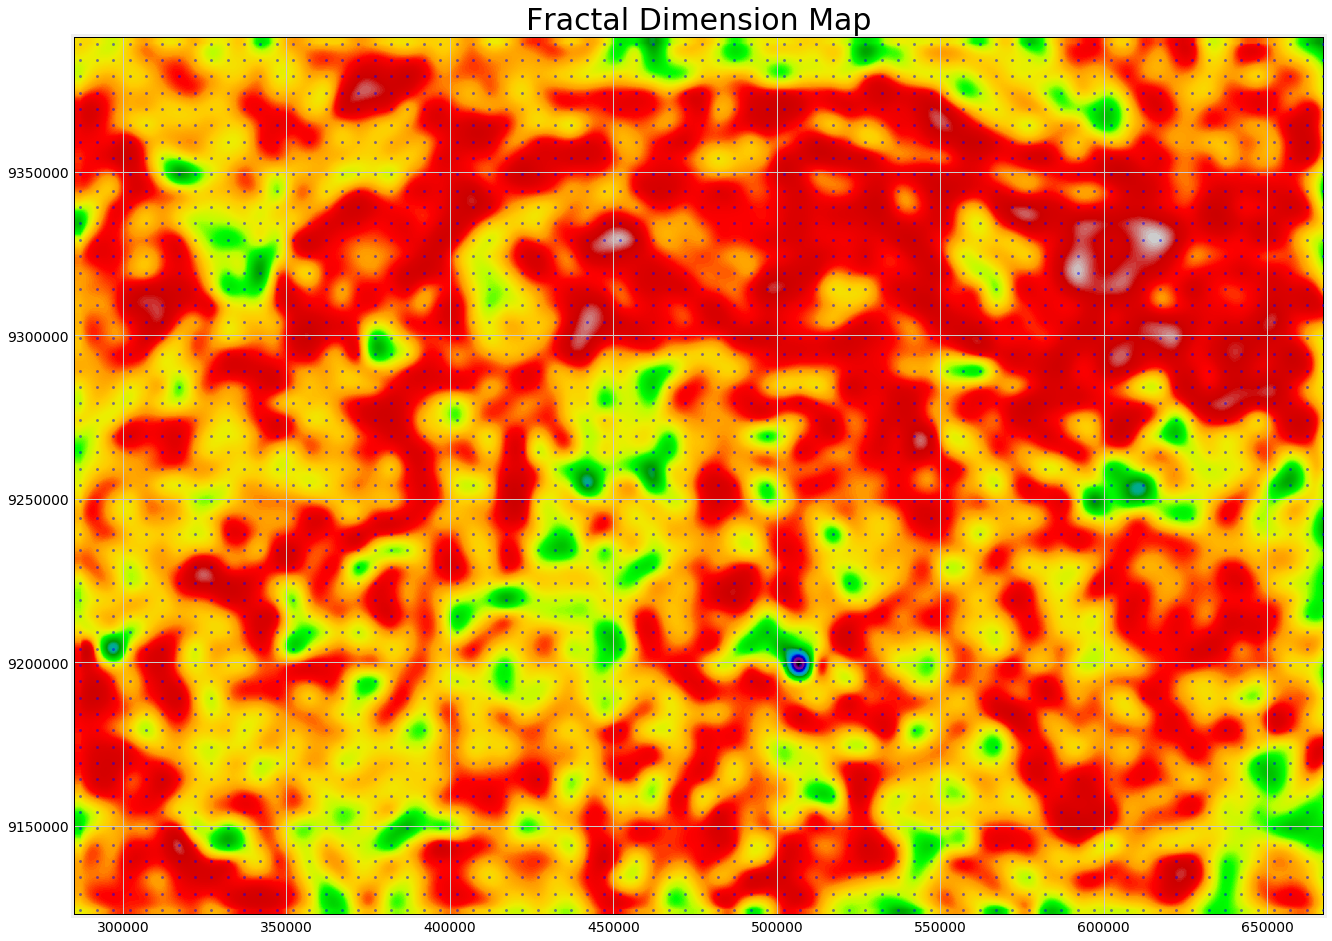

In [97]:
print(f'Map Path: {out_raster}')
#fish_net_gdf = gpd.read_file(fish_net)
w_area_gdf = gpd.read_file(work_area)
w_grid_gdf = gpd.read_file(out_work_grid)
input_raster_625 = rasterio.open(out_raster)

f, ax = plt.subplots(1, figsize=(20,20))

ax.set_title('Fractal Dimension Map', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=14)

show(input_raster_625, cmap='nipy_spectral', ax=ax, extent=[grid_min_x-init_size,grid_max_x+init_size,grid_min_y-init_size,grid_max_y+init_size])
#fish_net_gdf.plot(ax=ax, color='none', edgecolor='black')
w_area_gdf.plot(ax=ax, color='none', edgecolor='k', lw=5)
w_grid_gdf.plot(ax=ax, marker='o', markersize=5, color='blue', alpha=0.5)
input_raster_625.close
plt.show()